## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [612]:
# which metric file?
#binary_dirs = 'binaries_model1/'
binary_dirs = 'binaries_model4/'

How do we want to quantify how well we are doing?

In [613]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [614]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [627]:
# debugging
import metric_utils
reload(metric_utils)
from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [610]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)

Final box analytics:

In [628]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)

In [629]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [630]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


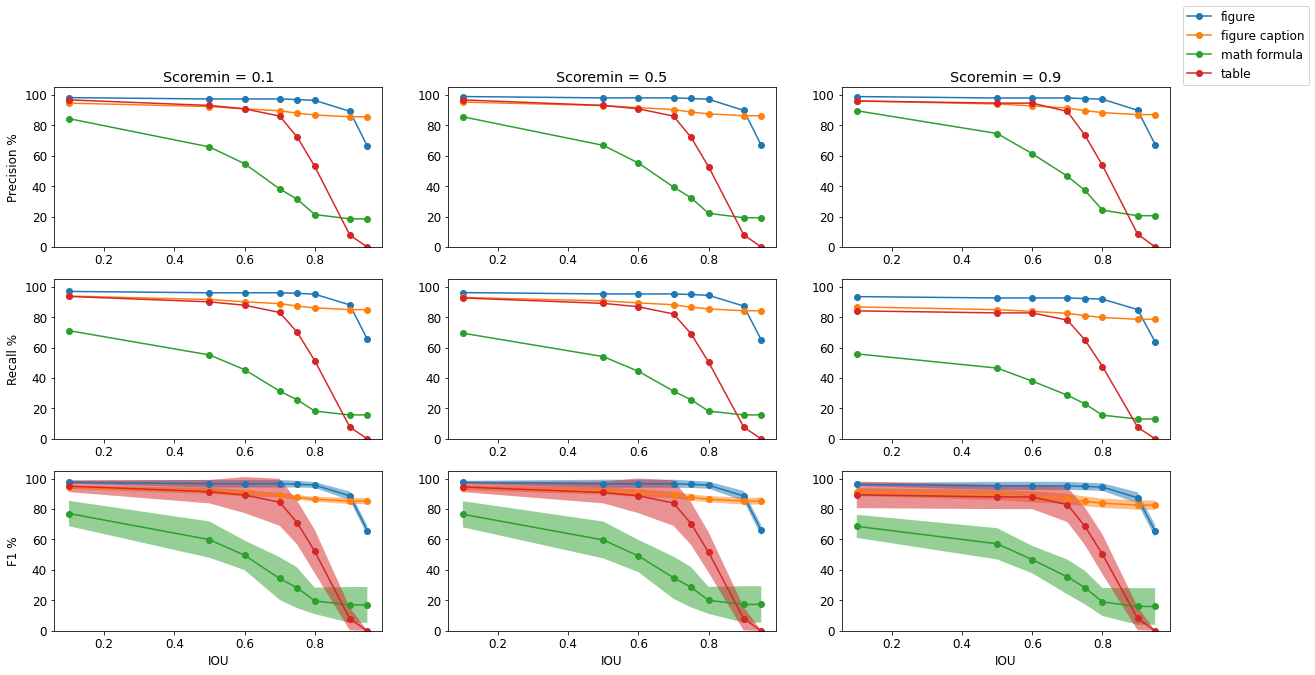

In [631]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [632]:
scoremin = 0.1 

What IOU cut-offs for each label? for reference:

In [633]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [634]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.8] # fig, fig+caption, math formula, table

In [635]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [636]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [637]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             468             114             75             
--------------------------------------------------------------------------------------------
TP              88.1%           84.8%           17.5%           54.7%          
FP              10.7%           14.5%           67.5%           42.7%          
FN              11.9%           15.2%           82.5%           45.3%          
--------------------------------------------------------------------------------------------
Precision       89.0+/-4.2%     85.1+/-4.2%     22.8+/-16.4%    53.1+/-13.5%   
Recall          88.1+/-3.3%     84.8+/-4.0%     19.9+/-16.6%    52.0+/-16.1%   
F1              88.5+/-3.6%     84.9+/-3.9%     21.1+/-16.5%    52.4+/-14.9%   


## Vs. Time
Also, let's plot metrics vs. year.

In [638]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [639]:
df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)

In [640]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1898-01-01,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1907-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1908-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1909-01-01,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1913-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [641]:
sampleHist = '10Y' # 5 years

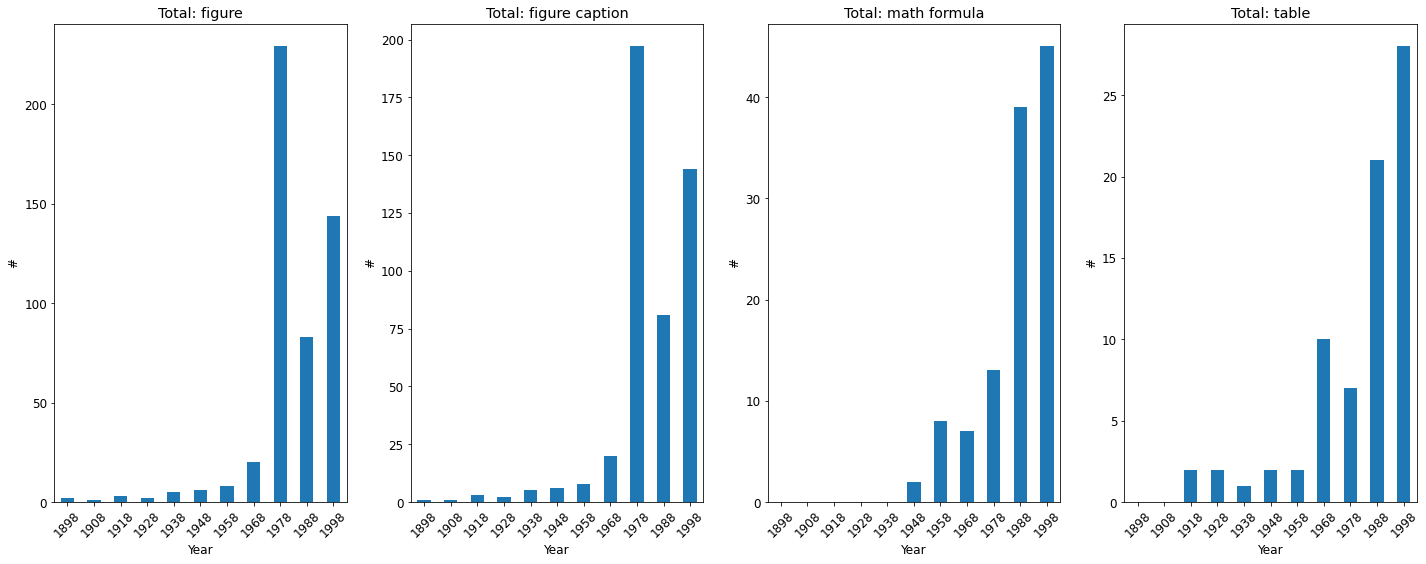

In [642]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

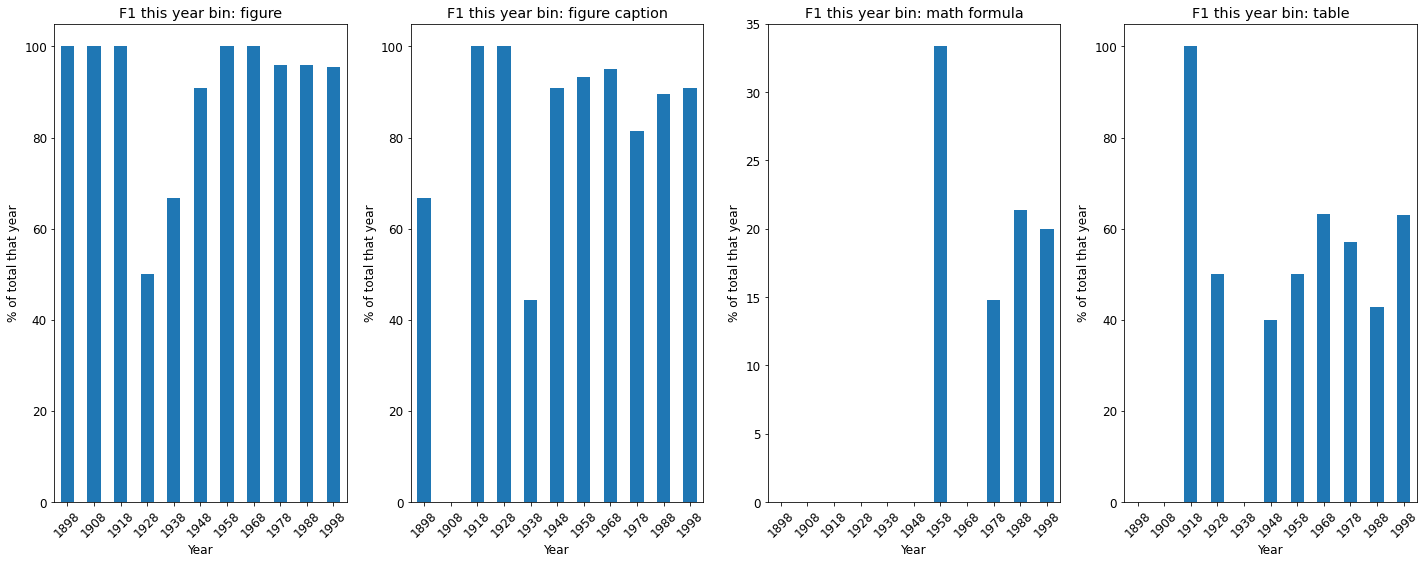

In [643]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

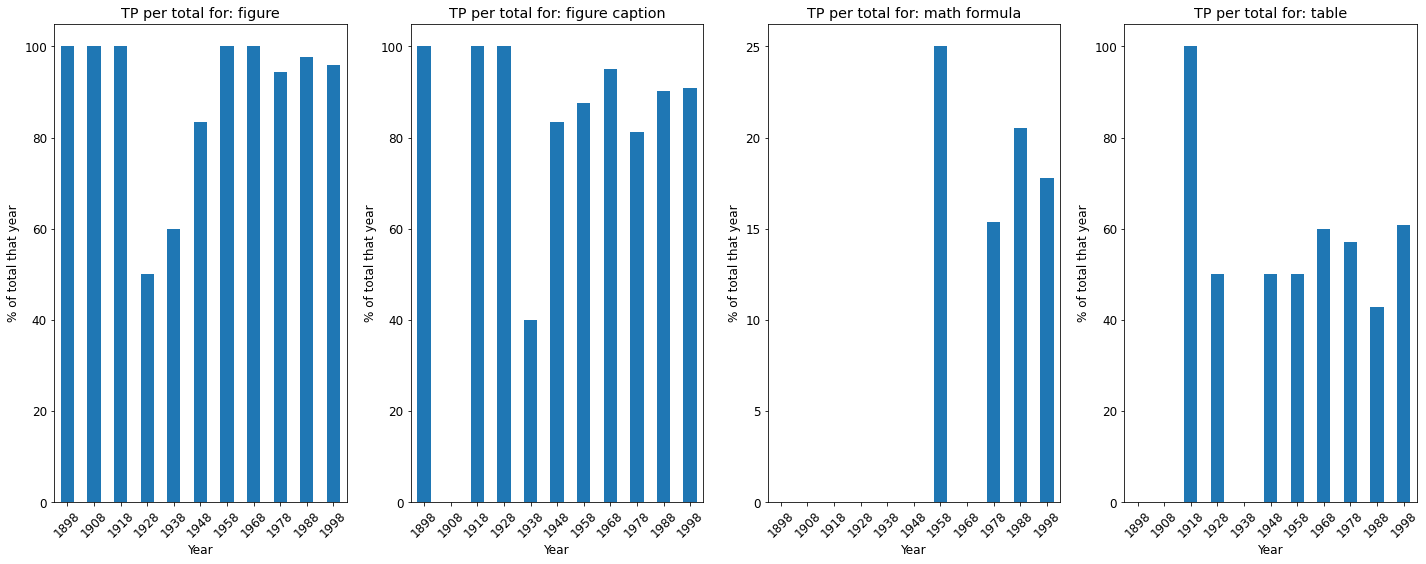

In [644]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


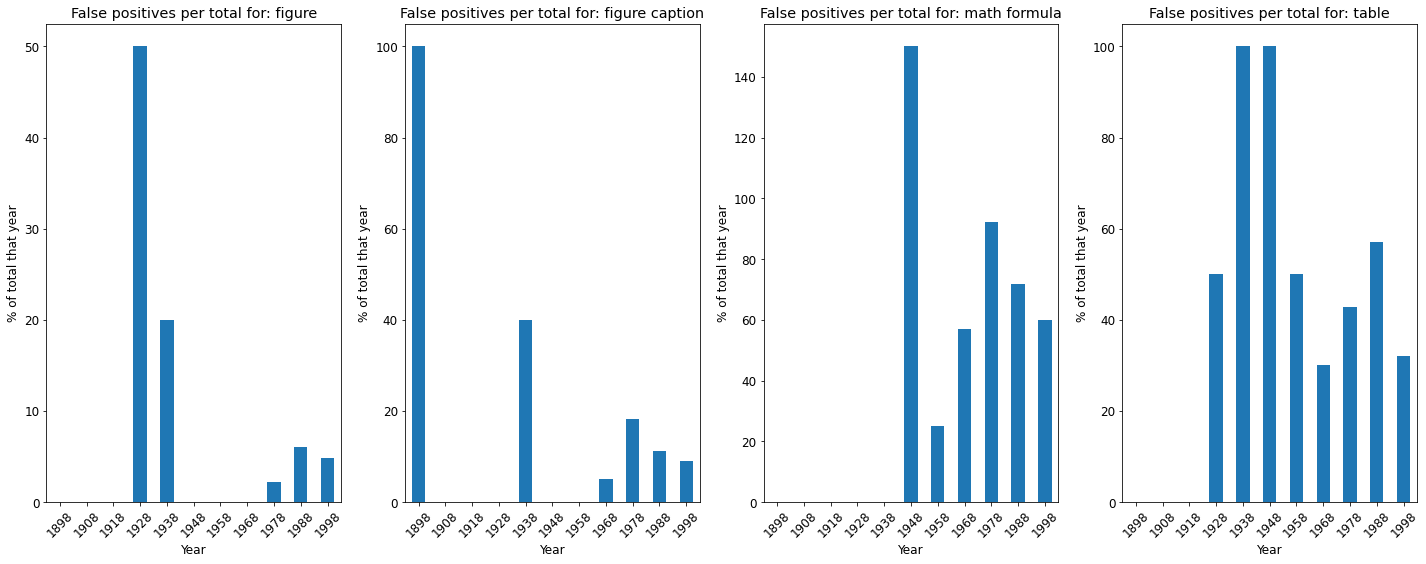

In [645]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

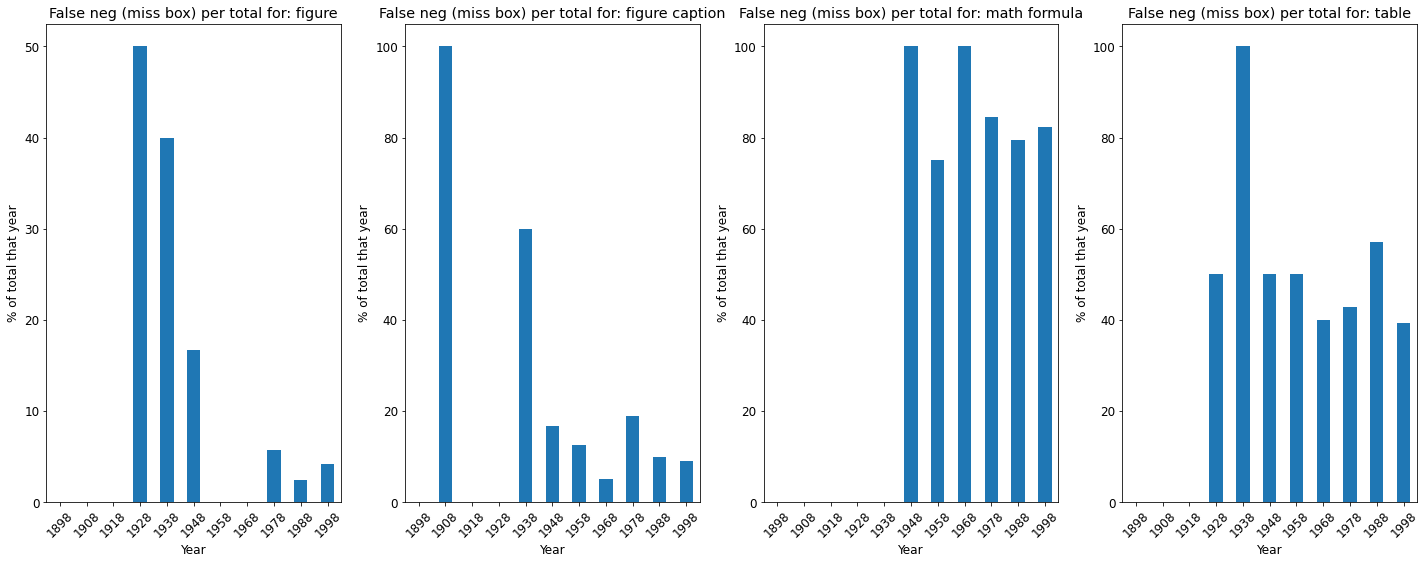

In [646]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

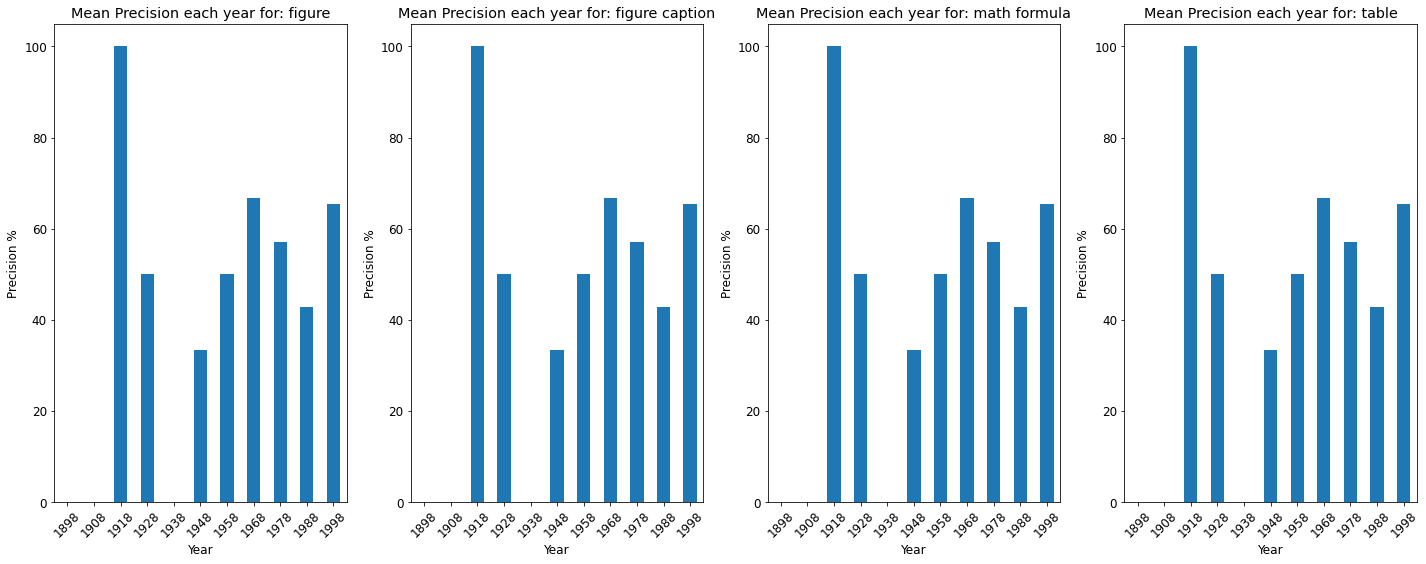

In [647]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

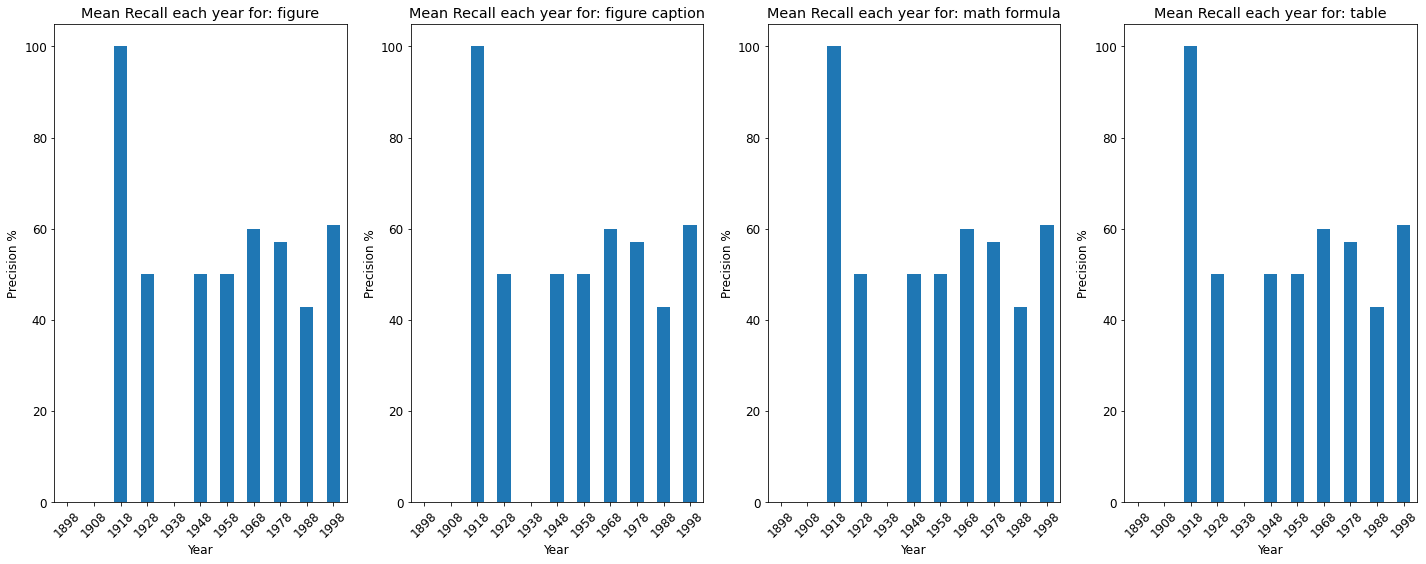

In [648]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

## 1. Raw-ish boxes

These have been cleaned for overlapping boxes -- only the higher score ones are taken if there is a large overlap.

Final metrics:

In [649]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [650]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.8            
# of objs       503             471             114             75             
--------------------------------------------------------------------------------------------
TP              60.2%           3.0%            17.5%           54.7%          
FP              38.6%           97.7%           67.5%           42.7%          
FN              39.8%           97.0%           82.5%           45.3%          
--------------------------------------------------------------------------------------------
Precision       61.2+/-2.7%     3.0+/-2.1%      21.6+/-7.0%     51.4+/-14.4%   
Recall          60.5+/-3.1%     3.2+/-2.4%      18.9+/-7.1%     50.1+/-14.6%   
F1              60.8+/-2.8%     3.1+/-2.2%      20.1+/-7.1%     50.7+/-14.5%   


IOU=0.6

In [432]:
#ioumin_per_label2 = [0.6,0.6,0.6,0.6]

ioumin_per_label2 = [0.8,0.8,0.8,0.8]

In [433]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           35.9%           6.1%            36.6%          
FP              8.7%            64.3%           78.9%           28.6%          
FN              10.1%           64.1%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     35.5+/-4.8%     5.1+/-7.0%      51.4+/-14.4%   
Recall          90.0+/-4.4%     35.6+/-4.3%     4.3+/-5.8%      34.2+/-14.9%   
F1              90.5+/-3.4%     35.5+/-4.5%     4.7+/-6.4%      40.8+/-15.5%   


Plot vs IOU:

In [434]:
iouvec = [0.05, 0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95]
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              sboxes_cleaned, slabels_cleaned, sscores_cleaned,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


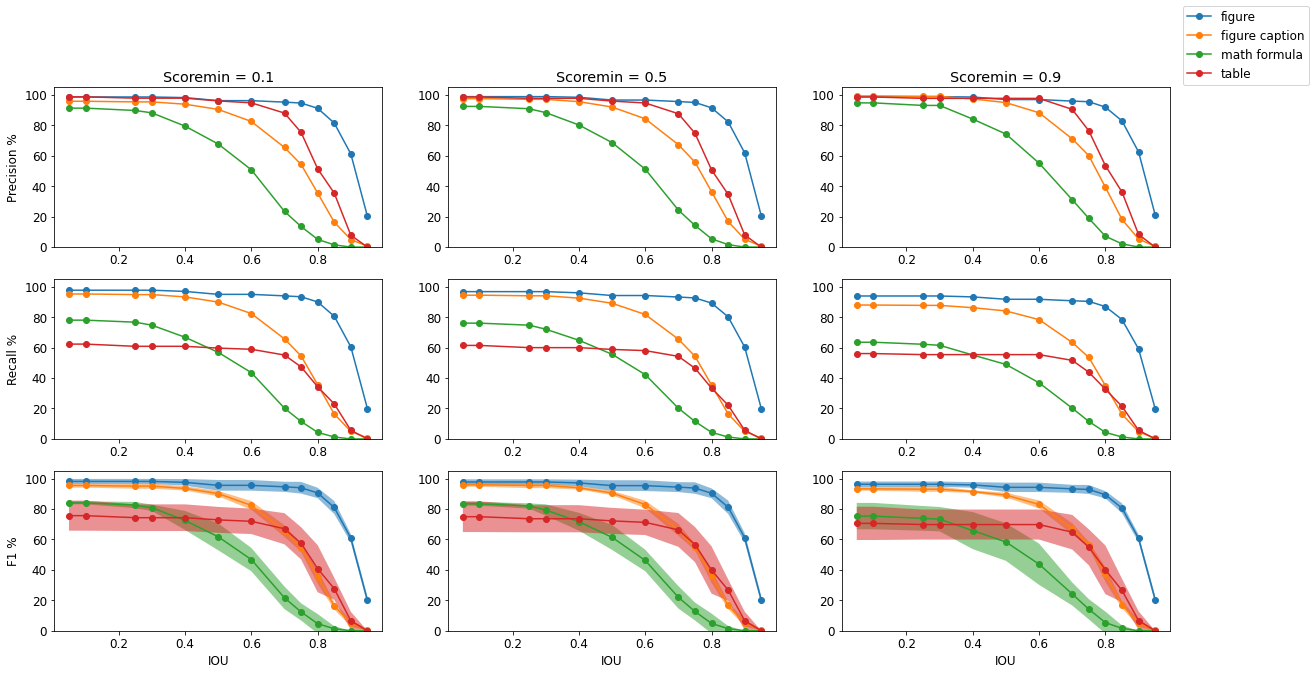

In [435]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## 2. Merge with PDF results

If any pdffigures2 results -- get these.

In [436]:
#boxes_pdf, labels_pdf, scores_pdf
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           40.1%           6.1%            36.6%          
FP              8.7%            60.1%           78.9%           28.6%          
FN              10.1%           59.9%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     39.7+/-4.7%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.0+/-4.4%     39.8+/-3.6%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.5+/-3.4%     39.7+/-4.1%     4.7+/-6.4%      39.9+/-19.3%   


In [437]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_pdf, labels_pdf, scores_pdf,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


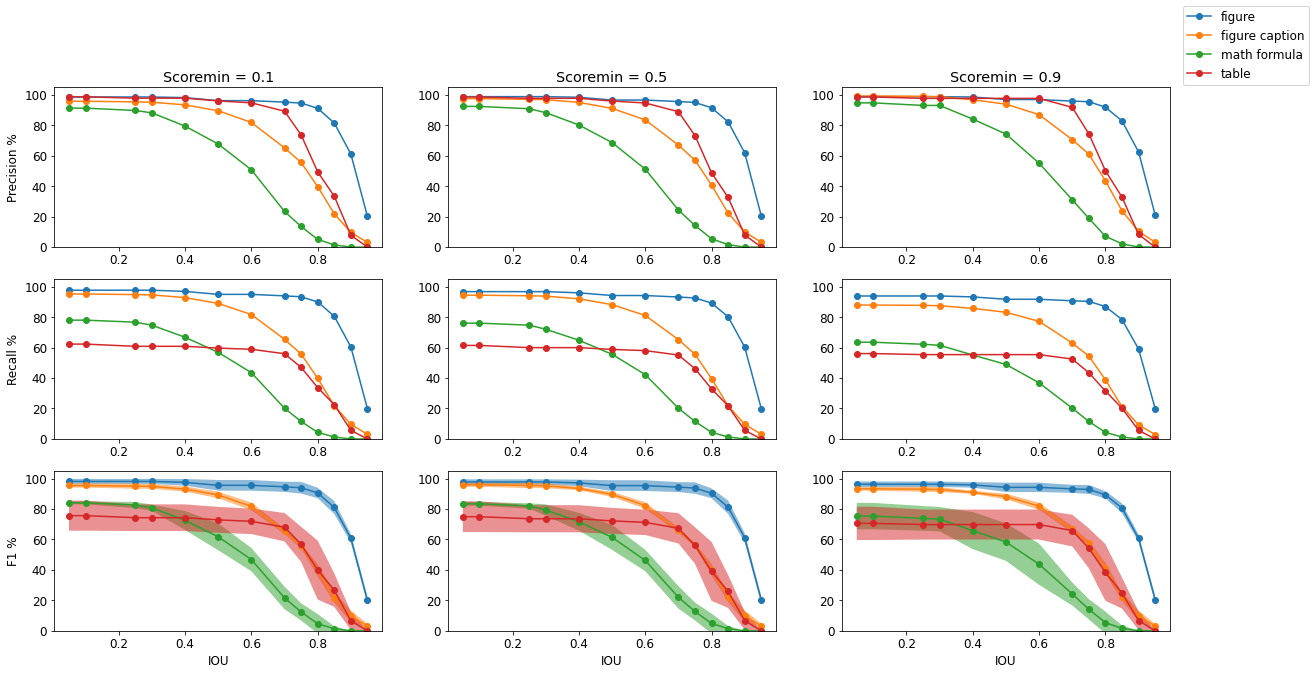

In [438]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Heuristics

If there are also heurstically found figure captions -- overlap these boxes.

In [439]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           59.9%           6.1%            36.6%          
FP              8.7%            40.6%           78.9%           28.6%          
FN              10.1%           40.1%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     59.4+/-4.1%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.0+/-4.4%     59.8+/-2.3%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.5+/-3.4%     59.5+/-3.1%     4.7+/-6.4%      39.9+/-19.3%   


In [440]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur, labels_heur, scores_heur,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


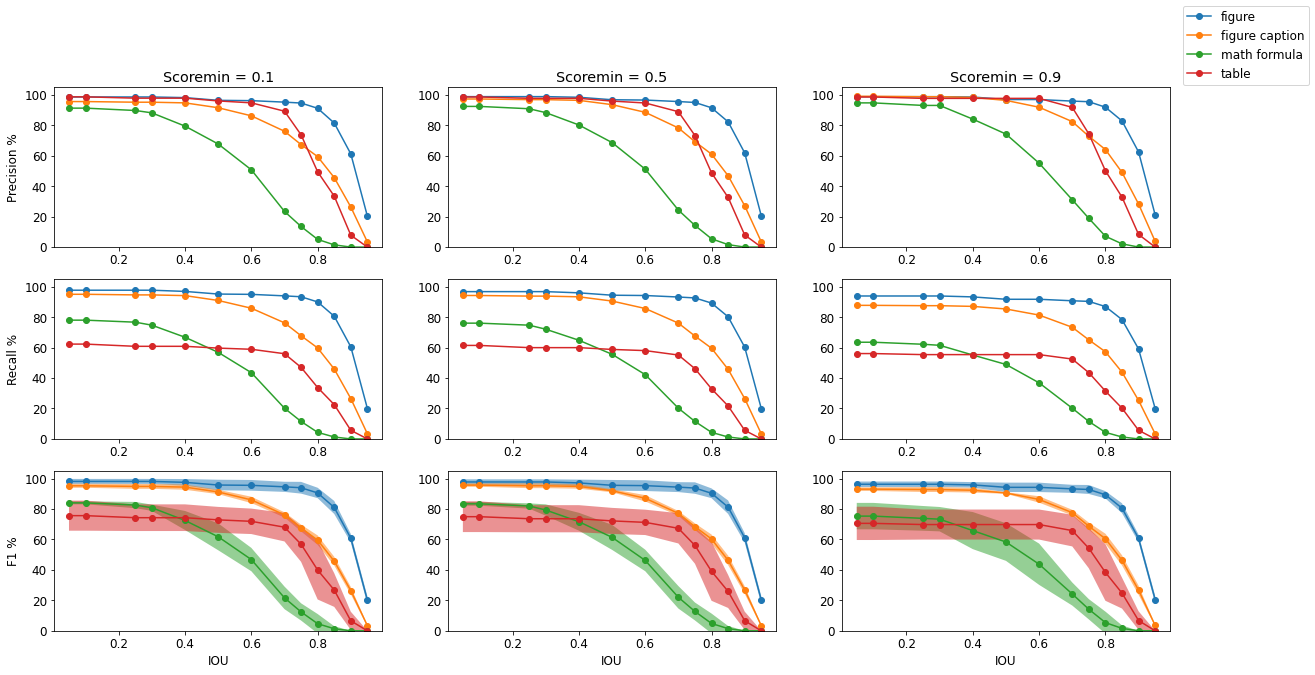

In [441]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Add in Heuristic Captions

If there are figures without captions, look for heurstically determined captions.

In [442]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           61.4%           6.1%            36.6%          
FP              8.7%            85.8%           78.9%           28.6%          
FN              10.1%           38.6%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     41.5+/-1.9%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.0+/-4.4%     61.2+/-3.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.5+/-3.4%     49.5+/-2.2%     4.7+/-6.4%      39.9+/-19.3%   


In [443]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_heur2, labels_heur2, scores_heur2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


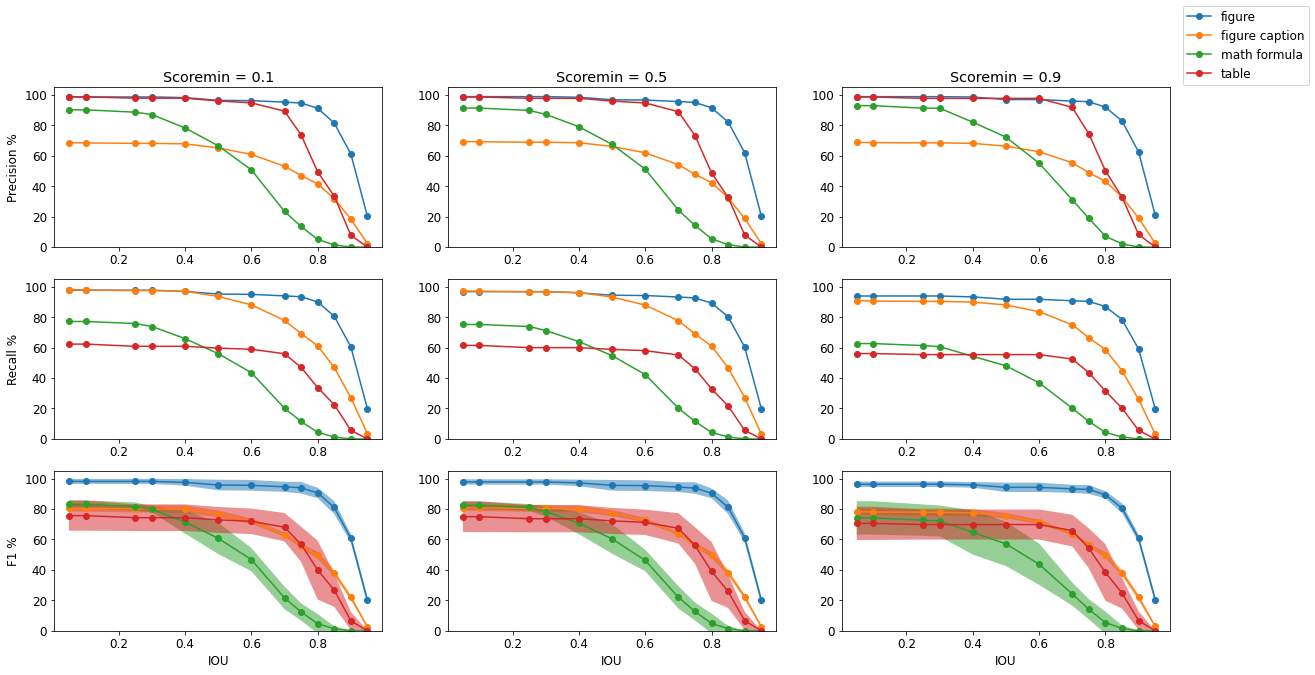

In [444]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand by paragraphs and words

### 1. Found boxes

In [445]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           89.2%           6.1%            36.6%          
FP              8.7%            54.4%           78.9%           28.6%          
FN              10.1%           10.8%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     62.1+/-3.2%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.0+/-4.4%     89.1+/-1.4%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.5+/-3.4%     73.2+/-2.7%     4.7+/-6.4%      39.9+/-19.3%   


In [446]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


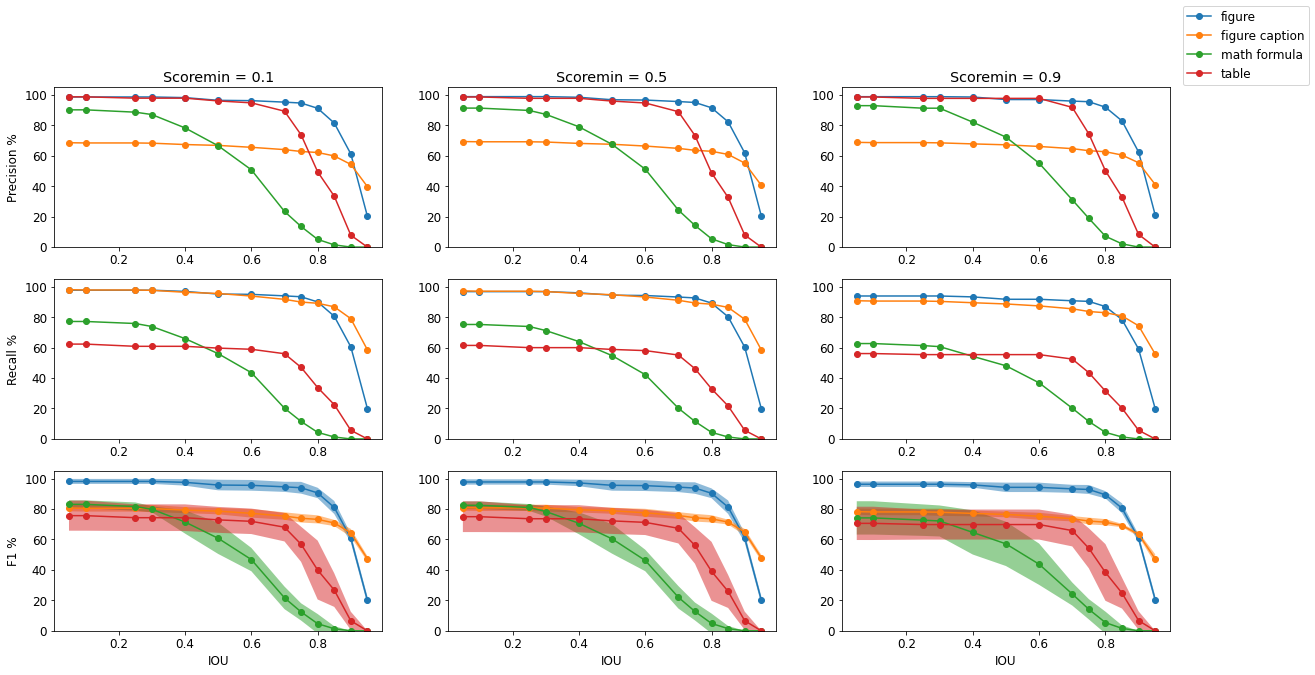

In [447]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. Expand trues as well -- this is technically already done in annotations? or no?

In [448]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.9%           89.8%           6.1%            36.6%          
FP              8.7%            53.7%           78.9%           28.6%          
FN              10.1%           10.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.1+/-2.7%     62.6+/-2.8%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.0+/-4.4%     89.8+/-1.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.5+/-3.4%     73.8+/-2.2%     4.7+/-6.4%      39.9+/-19.3%   


In [449]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_par_found, labels_par_found, scores_par_found,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


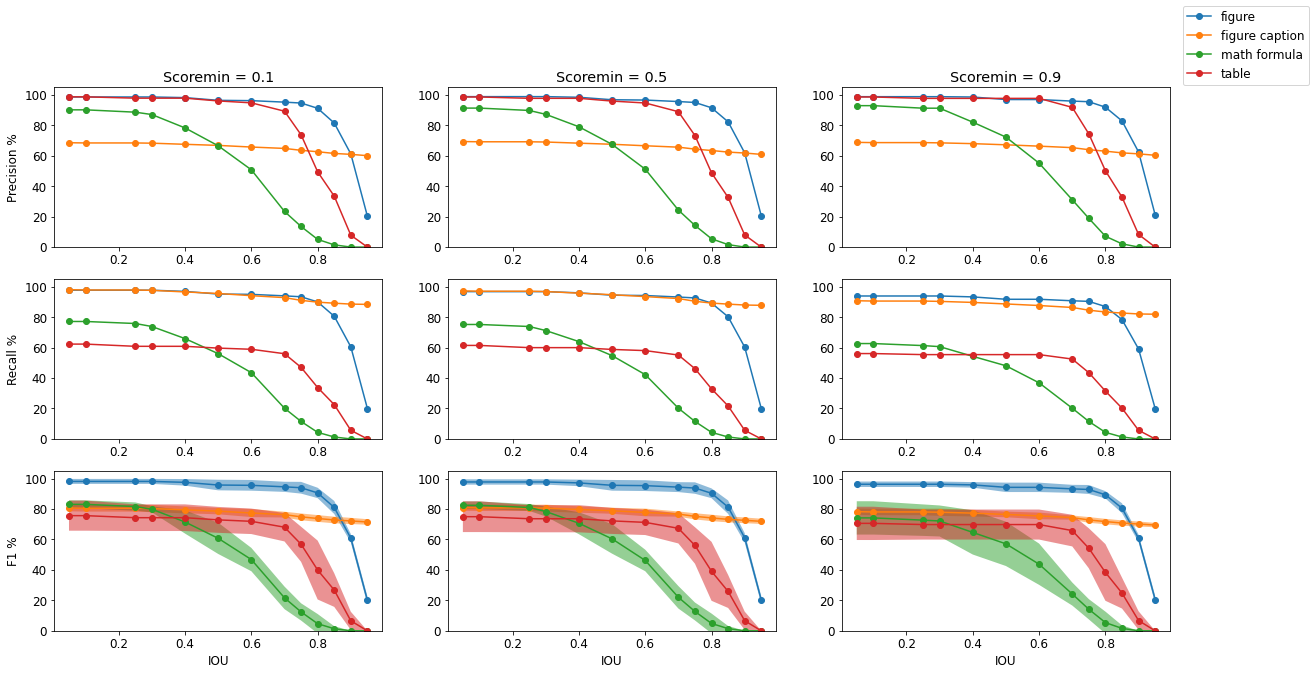

In [450]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Merge with Image Processing Squares

In [451]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.7%           89.8%           6.1%            36.6%          
FP              8.9%            53.7%           78.9%           28.6%          
FN              10.3%           10.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.0+/-2.4%     62.6+/-2.8%     5.1+/-7.0%      49.4+/-20.5%   
Recall          89.8+/-3.7%     89.8+/-1.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.4+/-2.9%     73.8+/-2.2%     4.7+/-6.4%      39.9+/-19.3%   


In [452]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq1, labels_sq1, scores_sq1,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


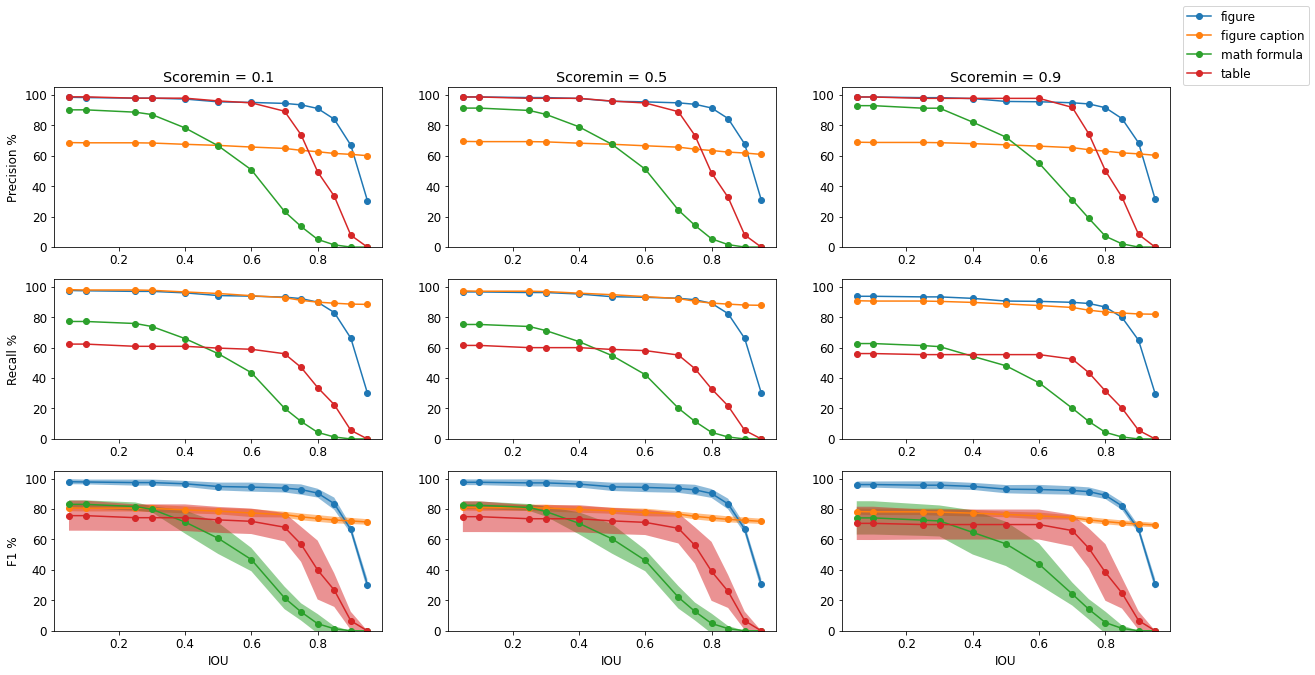

In [453]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Drop any very large captions

In [454]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              89.7%           89.8%           6.1%            36.6%          
FP              8.9%            53.1%           78.9%           28.6%          
FN              10.3%           10.2%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.0+/-2.4%     62.9+/-3.0%     5.1+/-7.0%      49.4+/-20.5%   
Recall          89.8+/-3.7%     89.8+/-1.0%     4.3+/-5.8%      33.8+/-17.8%   
F1              90.4+/-2.9%     74.0+/-2.3%     4.7+/-6.4%      39.9+/-19.3%   


In [455]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq2, labels_sq2, scores_sq2,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


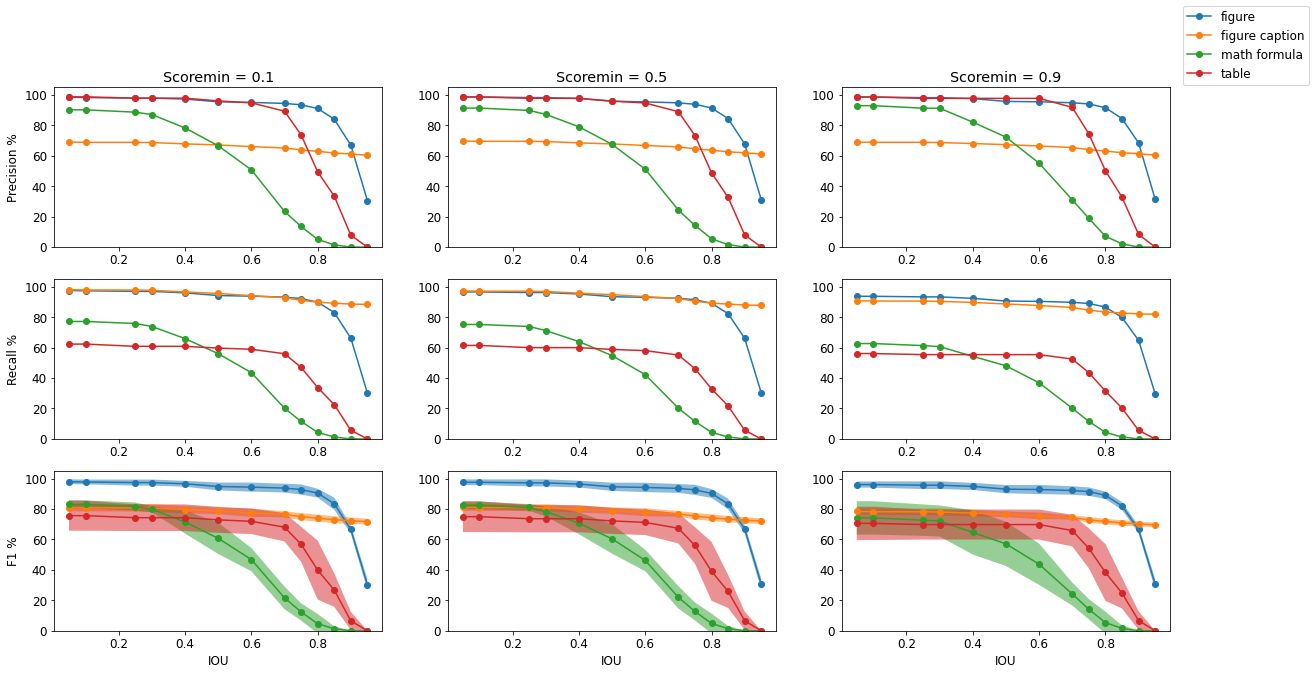

In [456]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Take out caption overlap with fig boxes -- why does this go back to table/math formula levels from before?

### 1. Found boxes

In [457]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox1,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             471             114             112            
--------------------------------------------------------------------------------------------
TP              91.3%           87.3%           6.1%            36.6%          
FP              7.4%            12.7%           78.9%           28.6%          
FN              8.7%            12.7%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       92.6+/-2.6%     87.3+/-2.2%     5.1+/-7.0%      49.4+/-20.5%   
Recall          91.4+/-4.0%     87.3+/-2.2%     4.3+/-5.8%      33.8+/-17.8%   
F1              92.0+/-3.1%     87.3+/-2.2%     4.7+/-6.4%      39.9+/-19.3%   


In [458]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox1,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


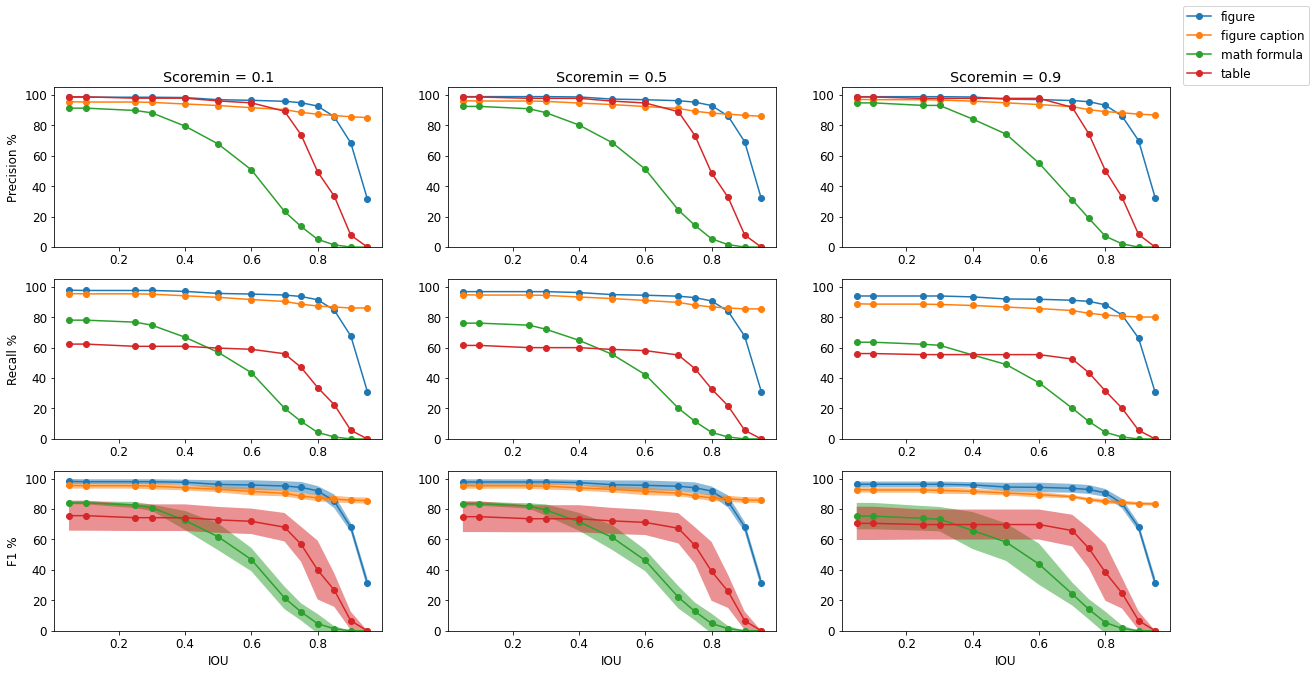

In [459]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True boxes

In [460]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              90.5%           88.5%           6.1%            36.6%          
FP              8.2%            12.8%           78.9%           28.6%          
FN              9.5%            11.5%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       91.9+/-3.3%     87.4+/-2.1%     5.1+/-7.0%      49.4+/-20.5%   
Recall          90.7+/-4.5%     88.6+/-2.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              91.2+/-3.8%     88.0+/-2.0%     4.7+/-6.4%      39.9+/-19.3%   


In [461]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq3, labels_sq3, scores_sq3,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


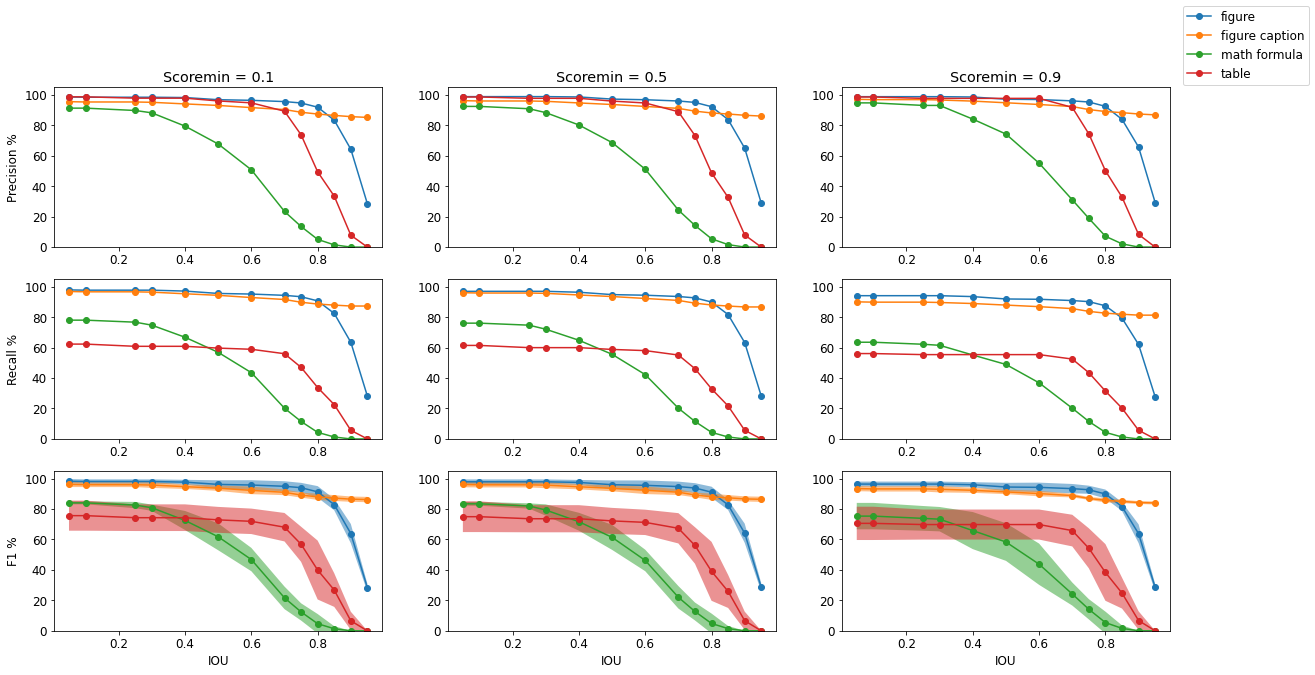

In [462]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand again for some reason??

In [463]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              93.6%           88.5%           6.1%            36.6%          
FP              5.2%            12.8%           78.9%           28.6%          
FN              6.4%            11.5%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       94.8+/-2.8%     87.4+/-2.1%     5.1+/-7.0%      49.4+/-20.5%   
Recall          93.7+/-3.6%     88.6+/-2.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              94.2+/-3.0%     88.0+/-2.0%     4.7+/-6.4%      39.9+/-19.3%   


In [464]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq4, labels_sq4, scores_sq4,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


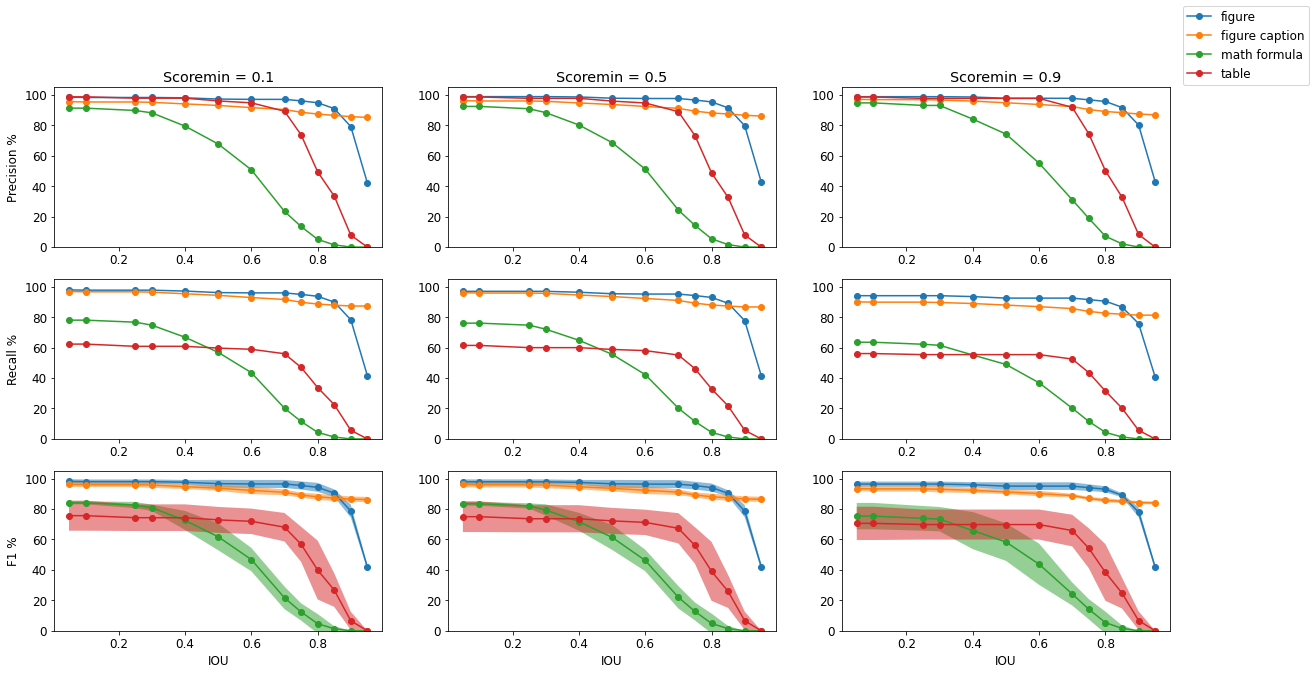

In [465]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Expand Area Above Captions

### 1. Found boxes

In [466]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox2,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              80.1%           88.5%           6.1%            36.6%          
FP              18.7%           12.8%           78.9%           28.6%          
FN              19.9%           11.5%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       81.0+/-3.6%     87.4+/-2.1%     5.1+/-7.0%      49.4+/-20.5%   
Recall          80.0+/-2.0%     88.6+/-2.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              80.5+/-2.6%     88.0+/-2.0%     4.7+/-6.4%      39.9+/-19.3%   


In [467]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox2,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


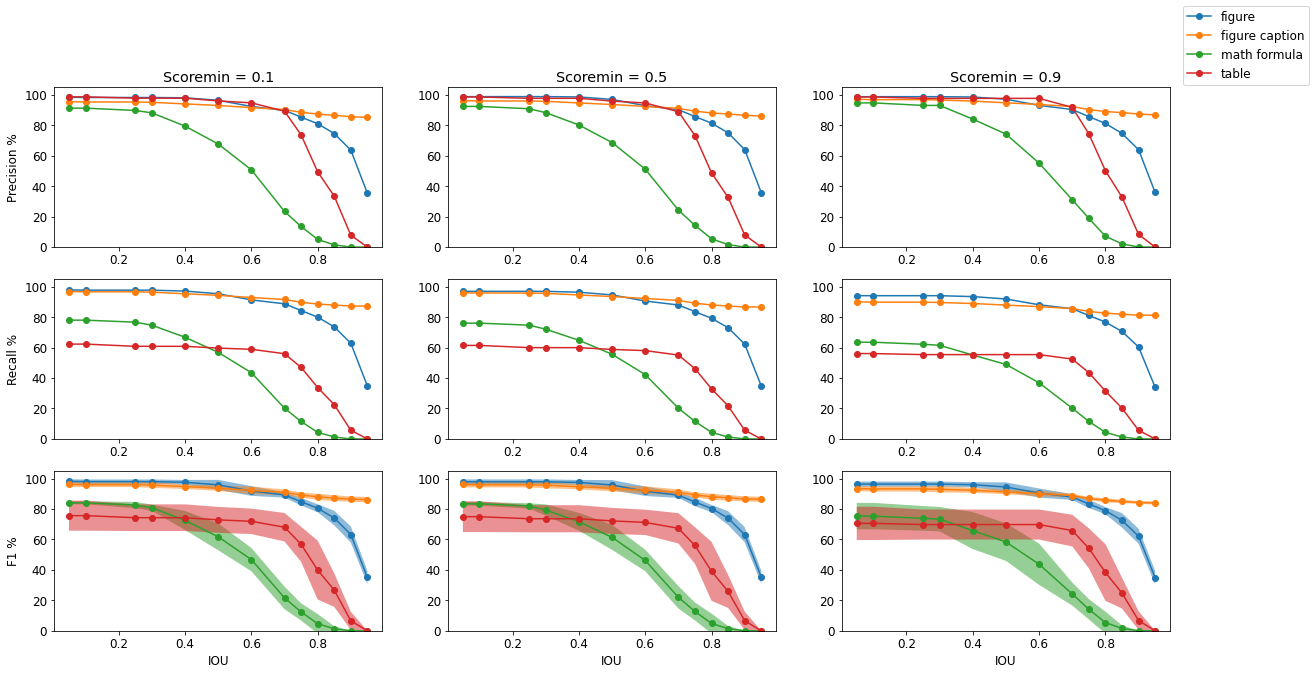

In [468]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

### 2. True Boxes

In [469]:
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label2,
                                              truebox3,boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
# combo metrics
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label2)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label2)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       503             468             114             112            
--------------------------------------------------------------------------------------------
TP              95.0%           88.5%           6.1%            36.6%          
FP              3.8%            12.8%           78.9%           28.6%          
FN              5.0%            11.5%           93.9%           63.4%          
--------------------------------------------------------------------------------------------
Precision       96.1+/-1.6%     87.4+/-2.1%     5.1+/-7.0%      49.4+/-20.5%   
Recall          95.0+/-3.1%     88.6+/-2.1%     4.3+/-5.8%      33.8+/-17.8%   
F1              95.6+/-2.1%     88.0+/-2.0%     4.7+/-6.4%      39.9+/-19.3%   


In [470]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouvec,
                                              truebox3,
                                              boxes_sq5, labels_sq5, scores_sq5,
                                                          n_folds_cv=n_folds_cv,seed=5)
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouvec)

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


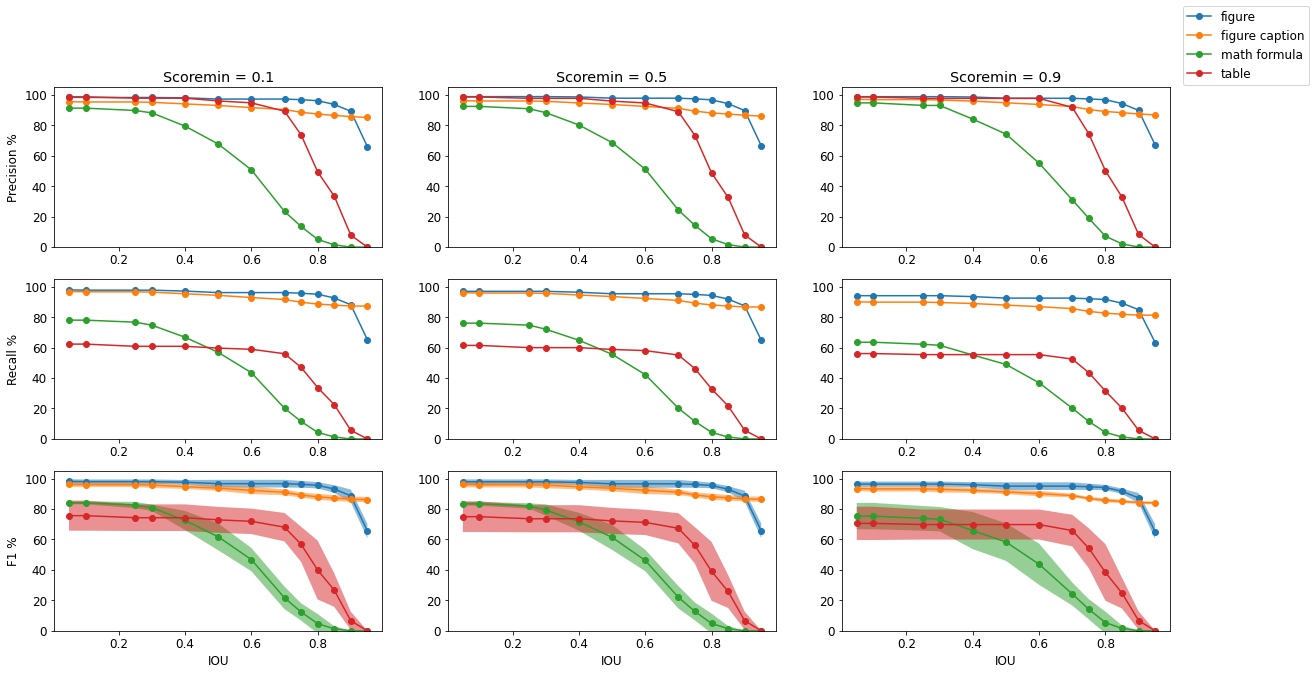

In [471]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouvec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouvec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouvec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouvec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

## Plot how metrics change with steps

In [472]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [651]:
# trueboxes = [truebox,truebox,truebox,truebox,truebox,truebox1,truebox1,
#              truebox1,truebox1,truebox2,truebox2,truebox2,truebox3]
# foundboxes = [sboxes_cleaned,boxes_pdf,boxes_heur,boxes_heur2,boxes_par_found,
#               boxes_par_found,boxes_sq1,boxes_sq2,boxes_sq3,boxes_sq3,boxes_sq4,boxes_sq5,boxes_sq5]
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_par_found,labels_par_found,
#              labels_sq1,labels_sq2,labels_sq3,labels_sq3,labels_sq4,labels_sq5,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_par_found,scores_par_found,
#              scores_sq1,scores_sq2,scores_sq3,scores_sq3,scores_sq4,scores_sq5,scores_sq5]


# # actual things
# trueboxes = [truebox, #1
#              truebox, #2
#              truebox, #3
#              truebox, #4
#              truebox1, #5
#              truebox1, #6
#              truebox2, #7
#              truebox3] #8
# foundboxes = [sboxes_cleaned, #1
#               boxes_pdf, #2
#               boxes_heur, #3
#               boxes_heur2, #4 --
#               boxes_sq1, #5
#               boxes_sq2, #6 --
#               boxes_sq4, #7
#               boxes_sq5] #8
# foundlabels=[slabels_cleaned,labels_pdf,labels_heur,labels_heur2,labels_sq1,labels_sq2,labels_sq4,labels_sq5]
# foundscores=[sscores_cleaned,scores_pdf,scores_heur,scores_heur2,scores_sq1,scores_sq2,scores_sq4,scores_sq5]


# paper order?
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             #truebox, #5
             truebox1, #6
             truebox1, #7
             truebox1, #8
             truebox1, #9
             truebox2, #10
             truebox3] #11
foundboxes = [boxes1,#1
              sboxes_cleaned, #2
              boxes_pdf, #3
              boxes_heur,#4
              #boxes_heur2, #5
              boxes_par_found, 
              boxes_sq1, 
              boxes_sq2, #6 --
              boxes_sq3, #6 --
              boxes_sq4, #7
              boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            #labels_heur2,
             labels_par_found,
             labels_sq1,
             labels_sq2,
             labels_sq3,
             labels_sq4,
             labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            #scores_heur2,
             scores_par_found,
             scores_sq1,
             scores_sq2,
             scores_sq3,
             scores_sq4,
             scores_sq5]

In [652]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

(10, 10, 10, 10)

In [653]:
#precsave[0]

In [654]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []

for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
    TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                  t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
    # combo metrics
    precisions, precision_stds, recalls, \
      recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                   LABELS,[scoremin],
                                                   iouvec2)

    TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
    precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
    #import sys; sys.exit()

In [655]:
#labels1
np.array(TPsave).shape, TPs.shape

((10, 4, 18), (4, 1, 18, 5))

In [656]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

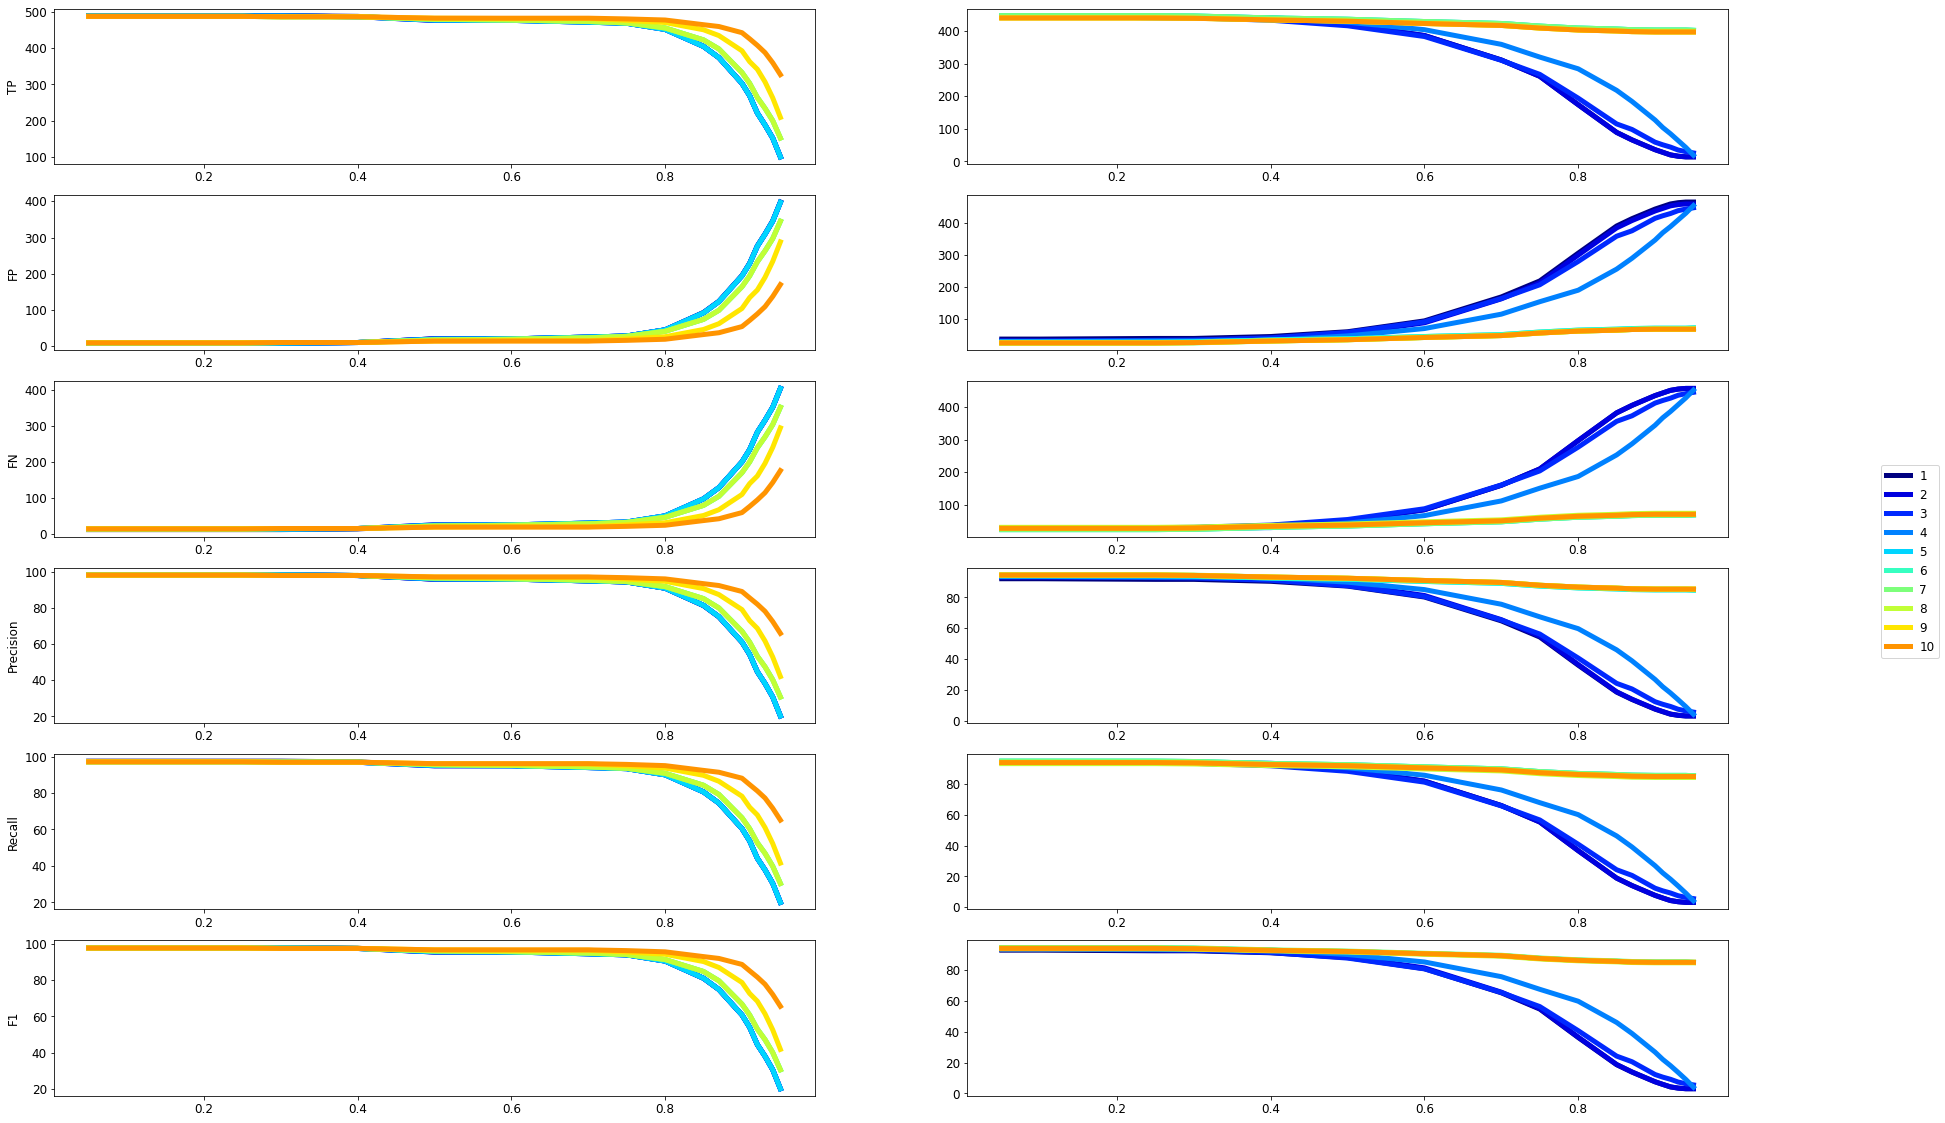

In [659]:
lw=5
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))

for ip,(p,r,f,tp,fp,fn) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave)):
    lwh=lw
    #lwh=5
    #if ip==8: lwh=10
    #lwh = 8-ip
    for il in range(len(LABELS[:2])):
        ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
        ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
        ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
        if il == 0:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
        else:
            ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
        ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
        ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

fig.legend(loc='center right')
plt.show()

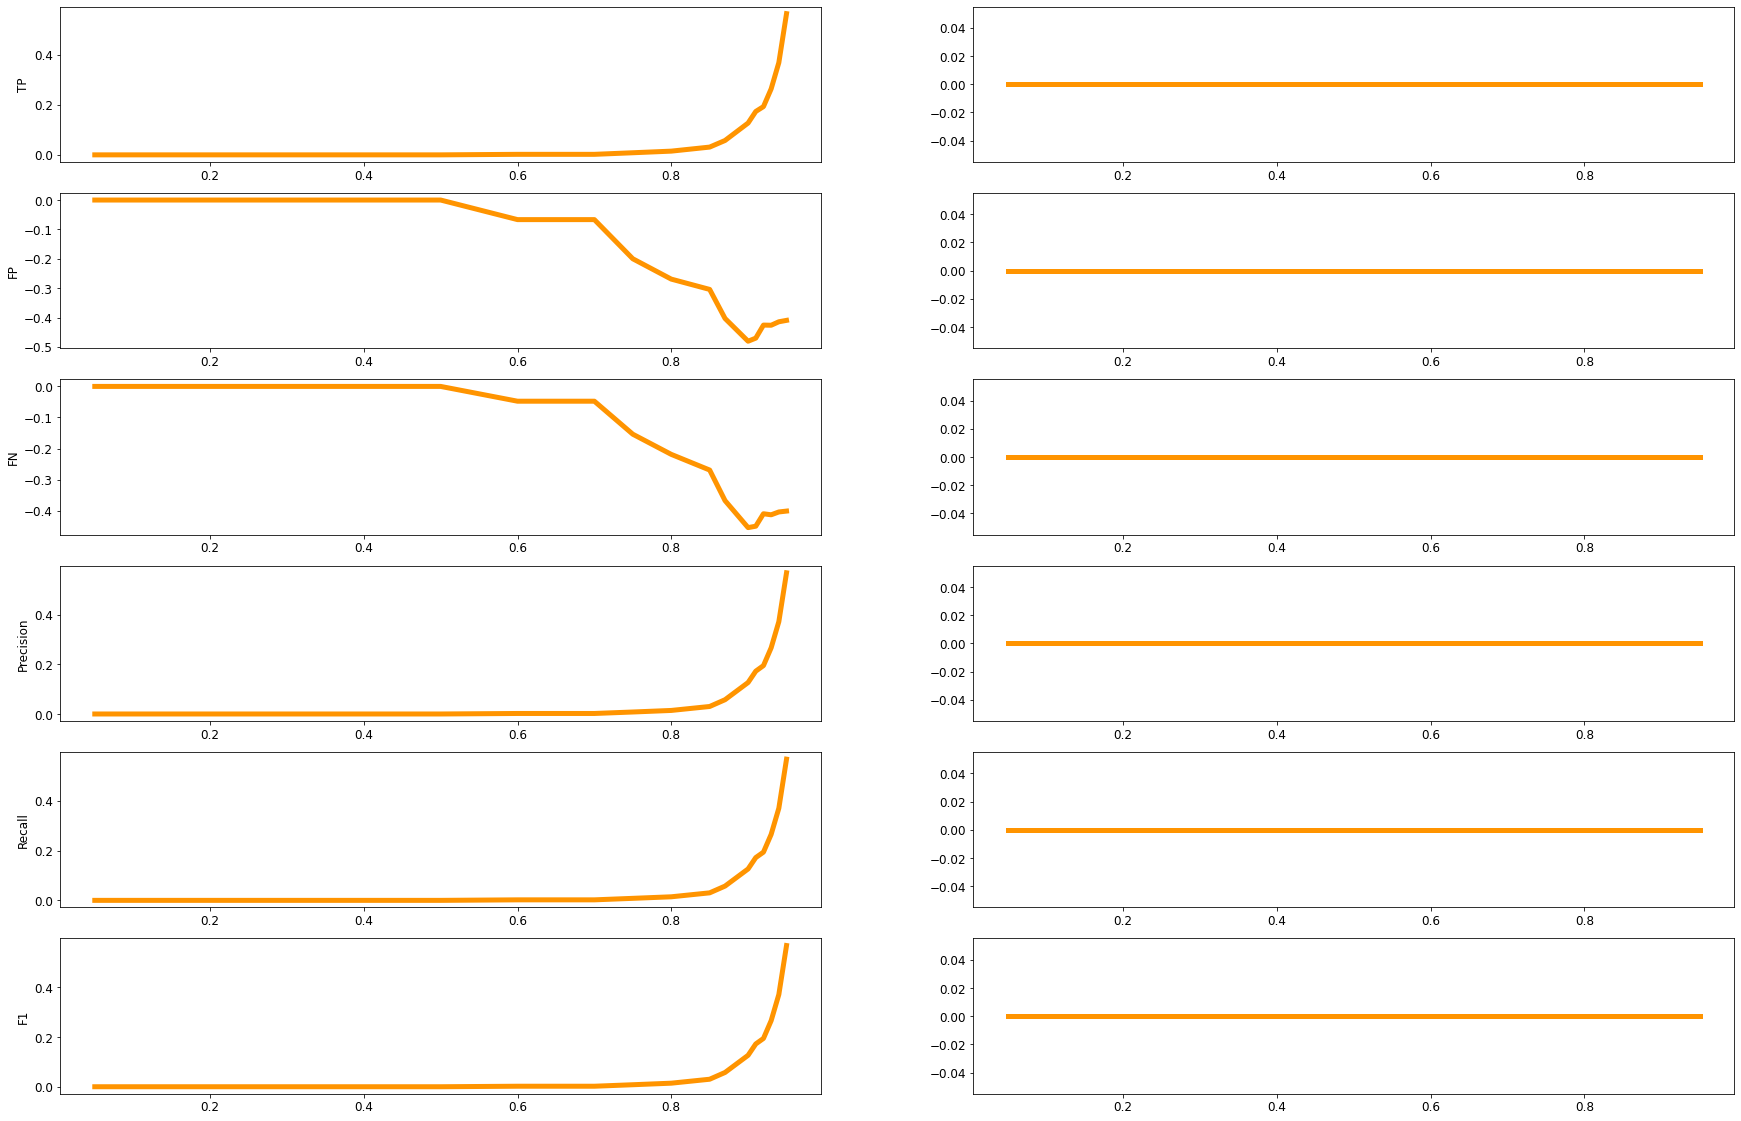

In [658]:
# plot ratio of last 2 changes
fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
lwh=5
for il in range(len(LABELS[:2])):
    ax[0][il].plot(iouvec2, TPsave[-1][il]/TPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[1][il].plot(iouvec2, FPsave[-1][il]/FPsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[2][il].plot(iouvec2, FNsave[-1][il]/FNsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[3][il].plot(iouvec2, precsave[-1][il]/precsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[4][il].plot(iouvec2, recsave[-1][il]/recsave[-2][il]-1,color=colors[ip],lw=lwh)
    ax[5][il].plot(iouvec2, f1save[-1][il]/f1save[-2][il]-1,color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')

plt.show()

In [408]:
# for ibb,(b1,b2) in enumerate(zip(boxes_heur,boxes_heur2)):
#     for bb1,bb2 in zip(b1,b2):
#         if (bb1 != bb2).any():
#             import sys; sys.exit()
#     # or, different lengths?
#     if len(b1) != len(b2):
#         import sys; sys.exit()

SystemExit: 

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [325]:
b1,b2

(array([[ 87.60063171, 231.28971863, 431.15203857, 239.53004456],
        [123.13404846, 121.2805481 , 377.30651855, 214.90023804],
        [332.4928894 , 270.01382446, 393.24142456, 282.88143921]]),
 array([[ 87.60063171, 231.28971863, 431.15203857, 239.53004456],
        [123.13404846, 121.2805481 , 377.30651855, 214.90023804],
        [332.4928894 , 270.01382446, 393.24142456, 282.88143921],
        [112.03764706, 327.52484848, 402.37176471, 335.9030303 ]]))

In [326]:
ibb

1

In [216]:
#boxes_heur[1], boxes_heur2[1]

In [215]:
#captionText_figcap[1]

In [200]:
bbox_figcap_pars[1]

[(553, 2679, 2000, 2734, 0.0),
 (554, 2623, 2001, 2677, 0.0),
 (555, 2338, 1933, 2392, 0.0),
 (628, 2224, 2004, 2278, 0.0),
 (558, 2111, 2004, 2165, 0.0),
 (560, 1600, 2008, 1653, 0.0),
 (567, 508, 1767, 562, 0.0)]

In [201]:
labels_heur[1], labels_heur2[1]

([1, 0, 2, -2], [1, 0, 2, -2])

In [88]:
from annotation_utils import get_all_ocr_files, collect_ocr_process_results, \
   get_makesense_info_and_years, get_years


/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/jillnaiman/.config/yt/ytrc is deprecated in favor of /Users/jillnaiman/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [90]:
# # let's get all of the ocr files
# ocrFiles = get_all_ocr_files()
# # get important quantities from these files
# print('retreiving OCR data, this can take a moment...')
# ws, paragraphs, squares, html, rotations = collect_ocr_process_results(ocrFiles)
# # create dataframe
# df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
#                    'hocr':html, 'rotation':rotations})#, 'pdfwords':pdfwords})
# df = df.drop_duplicates(subset='ws')
# df = df.set_index('ws')

# dfMakeSense = get_makesense_info_and_years(df)


retreiving OCR data, this can take a moment...
--- OCR retrieval: on 0 of 5515
--- OCR retrieval: on 1000 of 5515
--- OCR retrieval: on 2000 of 5515
--- OCR retrieval: on 3000 of 5515
--- OCR retrieval: on 4000 of 5515
--- OCR retrieval: on 5000 of 5515
---- for some reason 1901ApJ____14__269C_p7 is not in this list -----
---- for some reason 1996ApJ___466_1087P_p8 is not in this list -----
---- for some reason 1979AJ_____84__910B_p10 is not in this list -----
---- for some reason 1989AJ_____98_1398H_p5 is not in this list -----
---- for some reason 1994ApJS___95__457W_p15 is not in this list -----
---- for some reason 1990ApJ___351__443U_p6 is not in this list -----
---- for some reason 1963ApJ___137__280W_p8 is not in this list -----
---- for some reason 1990ApJ___365__510C_p2 is not in this list -----
---- for some reason 1991ApJS___76__455E_p6 is not in this list -----
---- for some reason 1992AJ____103_1151C_p9 is not in this list -----
---- for some reason 1982ApJS___50____1W_p18

In [202]:
dfMakeSense.loc[1]

filename                               1993ApJ___406__723B_p5
squares     [(1265, 2807, 1073, 234, figure caption), (120...
w                                                        2550
h                                                        3283
Name: 1, dtype: object

In [203]:
ff = imgs_name[1].split('/')[-1].split('.npz')[0]
dfMS = dfMakeSense.loc[dfMakeSense['filename']==ff]


In [204]:
dfMS

,filename,squares,w,h
99,1898ApJ_____8__252T_p0,"[(593, 721, 1396, 717, figure)]",2550,3300


In [205]:
fracx = dfMS['w'].values[0]*1.0/config.IMAGE_W
fracy = dfMS['h'].values[0]*1.0/config.IMAGE_H  
fracx,fracy

(4.98046875, 6.4453125)

In [206]:
from importlib import reload
import post_processing_utils
reload(post_processing_utils)

<module 'post_processing_utils' from '/Users/jillnaiman/figure_and_caption_extraction/post_processing_utils.py'>

In [207]:
from post_processing_utils import clean_merge_heurstic_captions, add_heuristic_captions

In [208]:
n=1
boxes_heur_here, labels_heur_here, scores_heur_here,\
  ibbOverlap_here = clean_merge_heurstic_captions(boxes_pdf[n], 
                                        labels_pdf[n], scores_pdf[n], 
                                        bbox_figcap_pars[n], LABELS,dfMS)

In [209]:
boxes_heur_here

array([[ 87.60063171, 231.28971863, 431.15203857, 239.53004456],
       [123.13404846, 121.2805481 , 377.30651855, 214.90023804],
       [332.4928894 , 270.01382446, 393.24142456, 282.88143921]])

In [210]:
ibbOverlap_here

[]

In [211]:
boxes_heur2_here, labels_heur2_here, scores_heur2_here = add_heuristic_captions(bbox_figcap_pars[n],
                                                              captionText_figcap[n],
                                                              ibbOverlap_here,
                                                              boxes_heur_here, 
                                                              labels_heur_here, 
                                                              scores_heur_here, dfMS)

In [212]:
boxes_heur2_here

array([[ 87.60063171, 231.28971863, 431.15203857, 239.53004456],
       [123.13404846, 121.2805481 , 377.30651855, 214.90023804],
       [332.4928894 , 270.01382446, 393.24142456, 282.88143921],
       [112.03764706, 327.52484848, 402.37176471, 335.9030303 ]])

In [214]:
labels_heur_here, labels_heur2_here

([1, 0, 2], [1, 0, 2, -2])

In [240]:
#for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
#    TPs, FPs, FNs, totalTrues = 
    
tp1,fp1,fn1,tt1 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.5],
                                                  [truebox[n]],
                              [boxes_heur_here], [labels_heur_here], 
                              [scores_heur_here],n_folds_cv=1,seed=5)


In [241]:
tp1.flatten(), tt1.flatten()

(array([1., 0., 0., 0.]), array([1., 0., 0., 0.]))

In [242]:
fp1.flatten()

array([0., 1., 1., 0.])

In [243]:
tp2,fp2,fn2,tt2 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.5],
                                                  [truebox[n]],
                              [boxes_heur2_here], [labels_heur2_here], 
                              [scores_heur2_here],n_folds_cv=1,seed=5)


In [244]:
tp2.flatten()

array([1., 0., 0., 0.])

In [245]:
fp2.flatten()

array([0., 2., 1., 0.])

In [246]:
truebox[1]

array([[119., 112., 399., 223.,   1.]])

In [247]:
boxes_heur_here

array([[ 87.60063171, 231.28971863, 431.15203857, 239.53004456],
       [123.13404846, 121.2805481 , 377.30651855, 214.90023804],
       [332.4928894 , 270.01382446, 393.24142456, 282.88143921]])

In [398]:
for iit,(t,fb1,fl1,fs1,fb2,fl2,fs2) in enumerate(zip(truebox, boxes_heur, labels_heur, scores_heur, boxes_heur2, labels_heur2, scores_heur2)):
    tp1,fp1,fn1,tt1 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.95],
                                                  [t],[fb1], [fl1], [fs1],n_folds_cv=1,seed=5)
    tp1=tp1.flatten(); fp1=fp1.flatten(); fn1=fn1.flatten(); tt1=tt1.flatten()
    tp2,fp2,fn2,tt2 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.95],
                                                  [t],[fb2], [fl2], [fs2],n_folds_cv=1,seed=5)
    tp2=tp2.flatten(); fp2=fp2.flatten(); fn2=fn2.flatten(); tt2=tt2.flatten()
    
    # check figs
    if fp1[0] != fp2[0]:
        import sys; sys.exit()


In [399]:
fp1, fp2

(array([0., 1., 0., 0.]), array([0., 2., 0., 0.]))

In [338]:
iit

17

In [481]:
from importlib import reload
import post_processing_utils
reload(post_processing_utils)
from post_processing_utils import clean_merge_heurstic_captions, add_heuristic_captions

In [504]:
n=10
boxes_heur_here, labels_heur_here, scores_heur_here,\
  ibbOverlap_here = clean_merge_heurstic_captions(boxes_pdf[n], 
                                        labels_pdf[n], scores_pdf[n], 
                                        bbox_figcap_pars[n], LABELS,dfMS)

In [505]:
boxes_heur_here

array([[227.74313354, 302.39030303, 370.30953979, 375.91418457],
       [235.36026001, 158.14422607, 366.65267944, 299.99075317],
       [286.31843137, 302.39030303, 310.81411765, 308.28606061]])

In [506]:
ibbOverlap_here

[0, 0]

In [507]:
boxes_heur2_here, labels_heur2_here, scores_heur2_here = add_heuristic_captions(bbox_figcap_pars[n],
                                                              captionText_figcap[n],
                                                              ibbOverlap_here,
                                                              boxes_heur_here, 
                                                              labels_heur_here, 
                                                              scores_heur_here, dfMS)

In [508]:
boxes_heur2_here

array([[227.74313354, 302.39030303, 370.30953979, 375.91418457],
       [235.36026001, 158.14422607, 366.65267944, 299.99075317],
       [286.31843137, 302.39030303, 310.81411765, 308.28606061],
       [ 80.5145098 , 164.15030303, 223.47294118, 173.45939394]])

In [509]:
labels_heur_here, labels_heur2_here

([1, 0, 1], [1, 0, 1, -2])

In [510]:
truebox[n]

array([[227., 135., 369., 300.,   1.],
       [289., 303., 308., 308.,   2.]])

In [520]:
import metric_utils
reload(metric_utils)
from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [521]:
tp2,fp2,fn2,tt2 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.5],
                                              [truebox[n]],
                                                [boxes_heur2_here], 
                                                [labels_heur2_here], 
                                                [scores_heur2_here],n_folds_cv=1,seed=5)
tp2=tp2.flatten(); fp2=fp2.flatten(); fn2=fn2.flatten(); tt2=tt2.flatten()
fp2

array([0., 2., 0., 0.])

In [519]:
truebox[n]

array([[227., 135., 369., 300.,   1.],
       [289., 303., 308., 308.,   2.]])

In [380]:
fn2

array([1., 1., 0., 0.])

In [381]:
fp1

array([0., 0., 0., 0.])

In [388]:
tp1,fp1,fn1,tt1 = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.95],
                                              [truebox[n]],
                                                [boxes_heur_here], 
                                                [labels_heur_here], 
                                                [scores_heur_here],n_folds_cv=1,seed=5)
tp1=tp1.flatten(); fp1=fp1.flatten(); fn1=fn1.flatten(); tt1=tt1.flatten()
fp1

[array([102., 140., 350., 260.,   1.]), array([217., 264., 237., 269.,   2.])]
 
 ----- 
[0, 1] [0, 1]
[102. 140. 350. 260.   1.]
 
[1. 0. 0. 0.]
[217. 264. 237. 269.   2.]
 
[1. 1. 0. 0.]
[[0, -1], [1, -1]] [[0.0, -1], [1.0, -1]] here
bbox, truecap 2 2
FPv here [0. 0. 0. 0.]
ind 0
ind 1
FPv after [1. 1. 0. 0.]


array([1., 1., 0., 0.])